In [1]:
%load_ext autoreload
%autoreload 2
print('\n')
print('=============loading external modules now=========')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
print(f'tensorflow version: {tf.__version__}')
from tensorflow.keras import layers
import os, glob, math, random, time, datetime, PIL, imageio
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from IPython import display
import xml.etree.ElementTree as ET 
print('\n')
print('=============loading user-defined modules now=========')
print('\n')
start_=time.time()
start=time.time()
from optimizers import *
print(f'\t\toptimizers took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from losses import *
print(f'\t\tlosses took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from g_model import *
print(f'\t\tgenerator model took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from d_model import *
print(f'\t\tdiscriminator model took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from static import *
print(f'\t\tstatic took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from onboarding import *
print(f'\t\tonboarding took {time.time()-start} s in loading')
print('======================')
print('\n')
start=time.time()
from generate_and_save_images import *
print(f'\t\tgenerate_and_save_images took {time.time()-start} s in loading')
print('======================')
from train_step import *
print(f'\tall user-defined modules took {time.time()-start_} s in loading')



=============loading external modules now=========
tensorflow version: 2.3.0


=============loading user-defined modules now=========


		optimizers took 0.0009086132049560547 s in loading


		losses took 0.0004355907440185547 s in loading


		generator model took 0.9199423789978027 s in loading


		discriminator model took 0.0005590915679931641 s in loading


		static took 5.507469177246094e-05 s in loading


		onboarding took 0.0019669532775878906 s in loading


		generate_and_save_images took 0.0005114078521728516 s in loading
	all user-defined modules took 0.9264717102050781 s in loading


In [2]:
train_step

In [3]:
images_inputs, normalized_image_vectors, breeds_names = onboarding(all_images, all_breeds)

25it [00:00, 1091.69it/s]


CPU times: user 384 ms, sys: 4.15 ms, total: 388 ms
Wall time: 404 ms


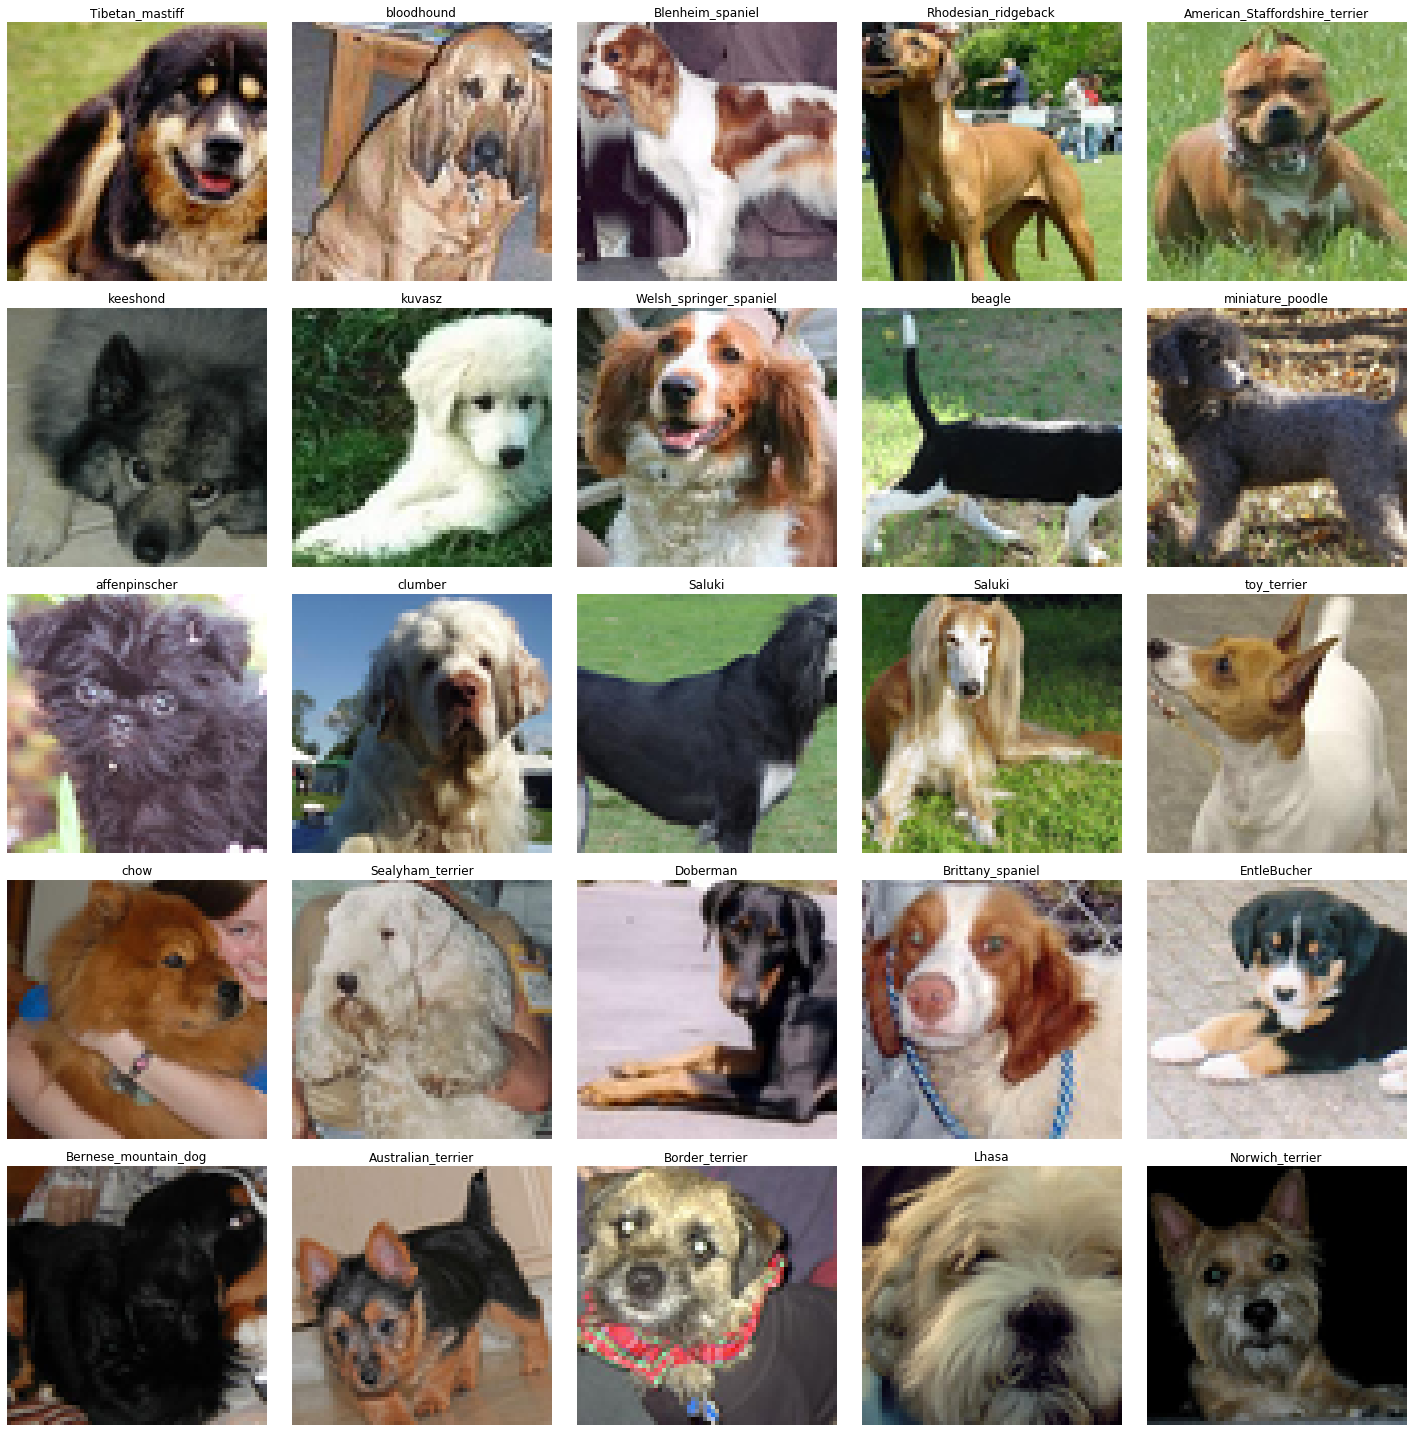

In [4]:
%%time
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for ax, id in tqdm(zip(axs.flatten(), rand_idx_viz)):
    ax.axis('off')
    ax.set_title(breeds_names[id].split('-')[1])
    img = Image.fromarray(images_inputs[id,:,:,:].astype('uint8'))
    ax.imshow(img)
    
plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('../figures/dogs.png')

# Generative Network

The purpose of a generative network is to use a deconvolution network and generate a random image from a random vector.
Reference: https://arxiv.org/pdf/1505.04366.pdf

(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 64, 64, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
CPU times: user 1.16 s, sys: 136 ms, total: 1.29 s
Wall time: 1.45 s


(1, 64, 64, 3)

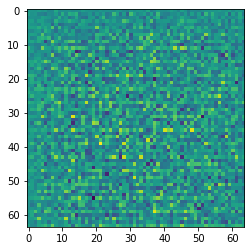

In [5]:
%%time
generator = g_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(type(generated_image))
plt.imshow((generated_image[0, :, :, 0]))
generator.predict(noise, steps=10).shape
# print(noise)

In [6]:
discriminator = d_model()
decision = discriminator(generated_image)
print(decision)

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 1)
tf.Tensor([[0.47481596]], shape=(1, 1), dtype=float32)


In [7]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
checkpoint_prefix = os.path.join('./training-checkpoints-5', "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
checkpoint_dir

'./training-checkpoints-2'

In [12]:
BUFFER_SIZE = 20000
BATCH_SIZE = 16
imagesIn = tf.cast(normalized_image_vectors, 'float32')
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>


# Training Loop

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('../training_results_5/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

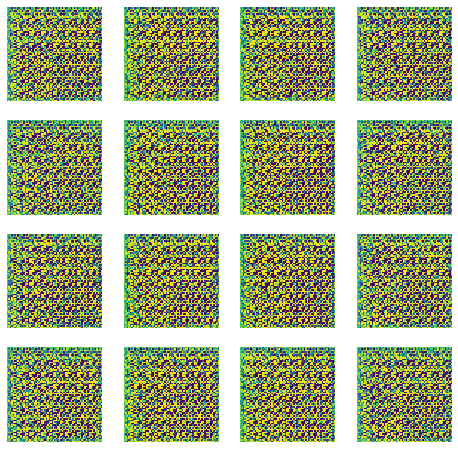

CPU times: user 19min 38s, sys: 3min 27s, total: 23min 6s
Wall time: 1h 30min 41s


In [17]:
%%time
print('Starting training')
train_dataset=ds
EPOCHS = 120
train(train_dataset, EPOCHS)

In [248]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [243]:
tf.constant([6])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([6], dtype=int32)>

In [44]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [74]:
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
for _ in range(10):
  discriminator_optimizer.minimize()  # Variables will be restored on creation.
status.assert_consumed()  # Optional sanity checks.
checkpoint.save(file_prefix=checkpoint_prefix)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f6cd474bc50> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd474b090>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd474b090> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f6cd475df50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f6cd46fa990> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f6cd4724890>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6cd4715b90> and <tensorflow.python.keras.layers.core.Dense object at 0x7f6cd4712950>).


TypeError: minimize() missing 2 required positional arguments: 'loss' and 'var_list'

In [23]:
import glob, imageio

anim_file = 'dcgan-2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../iter2/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [22]:
!ls ../iter2

image_at_epoch_0001.png  image_at_epoch_0401.png  image_at_epoch_0801.png
image_at_epoch_0002.png  image_at_epoch_0402.png  image_at_epoch_0802.png
image_at_epoch_0003.png  image_at_epoch_0403.png  image_at_epoch_0803.png
image_at_epoch_0004.png  image_at_epoch_0404.png  image_at_epoch_0804.png
image_at_epoch_0005.png  image_at_epoch_0405.png  image_at_epoch_0805.png
image_at_epoch_0006.png  image_at_epoch_0406.png  image_at_epoch_0806.png
image_at_epoch_0007.png  image_at_epoch_0407.png  image_at_epoch_0807.png
image_at_epoch_0008.png  image_at_epoch_0408.png  image_at_epoch_0808.png
image_at_epoch_0009.png  image_at_epoch_0409.png  image_at_epoch_0809.png
image_at_epoch_0010.png  image_at_epoch_0410.png  image_at_epoch_0810.png
image_at_epoch_0011.png  image_at_epoch_0411.png  image_at_epoch_0811.png
image_at_epoch_0012.png  image_at_epoch_0412.png  image_at_epoch_0812.png
image_at_epoch_0013.png  image_at_epoch_0413.png  image_at_epoch_0813.png
image_at_epoch_0014.png  image_at_epoc

In [257]:
pip show protobuf

Name: protobuf
Version: 3.13.0
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: None
Author-email: None
License: 3-Clause BSD License
Location: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages
Requires: six, setuptools
Required-by: tensorflow-serving-api, tensorflow-docs, sagemaker, protobuf3-to-dict, tensorflow-gpu, tensorboard
Note: you may need to restart the kernel to use updated packages.


In [258]:
pip install --upgrade protobuf

Requirement already up-to-date: protobuf in /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages (3.13.0)
Note: you may need to restart the kernel to use updated packages.


In [260]:
anim_file

'dcgan.gif'

In [39]:
pwd

'/home/ubuntu/oh-my-dog/src'

In [92]:
int(4.5)

4